#Projeto de análise exploratória e construção de modelo preditivo de notas atribuídas pelos usuários da plataforma IMDB.

Feito por: Mariana Silva de Oliveira

###Importação das bibliotecas e pacotes do Python

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
from scipy import stats


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Exploração inicial: conhecendo as variáveis e a saúde dos dados

In [111]:
dados = pd.read_csv("desafio_indicium_imdb.csv")
dados.head(5)

,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,1,The Godfather,1972,A,175 min,"Crime, Drama",9.20,An organized crime dynasty's aging patriarch t...,100.00,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
1,2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.00,When the menace known as the Joker wreaks havo...,84.00,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
2,3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.00,The early life and career of Vito Corleone in ...,90.00,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
3,4,12 Angry Men,1957,U,96 min,"Crime, Drama",9.00,A jury holdout attempts to prevent a miscarria...,96.00,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"
4,5,The Lord of the Rings: The Return of the King,2003,U,201 min,"Action, Adventure, Drama",8.90,Gandalf and Aragorn lead the World of Men agai...,94.00,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,"377,845,905"


In [112]:
print(f'Existem no dataset {dados.duplicated().sum()} instâncias duplicadas.')

Existem no dataset 0 instâncias duplicadas.


In [113]:
print(f"A base de dados aprensenta {dados.shape[0]} linhas e {dados.shape[1]} colunas.")
print("="*50)
display(dados.info())

A base de dados aprensenta 999 linhas e 16 colunas.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     999 non-null    int64  
 1   Series_Title   999 non-null    object 
 2   Released_Year  999 non-null    object 
 3   Certificate    898 non-null    object 
 4   Runtime        999 non-null    object 
 5   Genre          999 non-null    object 
 6   IMDB_Rating    999 non-null    float64
 7   Overview       999 non-null    object 
 8   Meta_score     842 non-null    float64
 9   Director       999 non-null    object 
 10  Star1          999 non-null    object 
 11  Star2          999 non-null    object 
 12  Star3          999 non-null    object 
 13  Star4          999 non-null    object 
 14  No_of_Votes    999 non-null    int64  
 15  Gross          830 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usa

None

Pontos de atenção:
* A variável **Gross** deve ser convertida para um tipo numérico, para que possamos compreendê-la utilizando certos métodos do Pandas (como o **describe**) e aplicá-la em cálculos.
* Vamos converter as colunas **Released_Year** e **Runtime** para o tipo inteiro.
* As variáveis **Meta_score** e **Gross** apresentam certa quantidade de valores nulos. Felizmente, a quantidade de nulos corresponde a menos de 20% dos dados totais de cada uma, o que não as inutiliza para a análise. Portanto, não vamos descartá-las.

In [114]:
dados.columns

Index(['Unnamed: 0', 'Series_Title', 'Released_Year', 'Certificate', 'Runtime',
       'Genre', 'IMDB_Rating', 'Overview', 'Meta_score', 'Director', 'Star1',
       'Star2', 'Star3', 'Star4', 'No_of_Votes', 'Gross'],
      dtype='object')

### Tratamentos iniciais:
* Eliminar a coluna **Unnamed: 0**, que não é relevante.
* Alterar o tipo das colunas **Gross**, **Runtime** e **Release_Year**
* Dropar valores nulos

In [115]:
#tirando a primeira vírgula dos números na coluna Gross
dados['Gross'] = dados['Gross'].apply(lambda x: str(x).replace(",", ""))

In [116]:
dados['Gross']

,Gross
0,134966411
1,534858444
2,57300000
3,4360000
4,377845905
...,...
994,nan
995,nan
996,30500000
997,nan


In [117]:
#convertendo a coluna Gross para o tipo float
dados['Gross'] = dados['Gross'].astype('float64')

In [118]:
dados['Runtime'] = dados['Runtime'].apply(lambda x: str(x).replace(" min", ""))

In [119]:
dados['Runtime'] = dados['Runtime'].astype('int64')

In [120]:
#eliminando acoluna Unnamed: 0
dados = dados.drop(columns = "Unnamed: 0")

In [121]:
#eliminando os valors nulos
dados = dados.dropna()

In [122]:
dados['Released_Year'].unique()

array(['1972', '2008', '1974', '1957', '2003', '1994', '1993', '2010',
       '1999', '2001', '1966', '2002', '1990', '1980', '1975', '2019',
       '2014', '1998', '1997', '1995', '1991', '1977', '1954', '2011',
       '2006', '2000', '1988', '1985', '1968', '1960', '1942', '1936',
       '1931', '2018', '2016', '2017', '2012', '2009', '1981', '1979',
       '1964', '2004', '1992', '1987', '1986', '1984', '1983', '1976',
       '1973', '1971', '1965', '1962', '1959', '1958', '1952', '1944',
       '1941', '2013', '2007', '2005', '1989', '1963', '1950', '1948',
       '2015', '1996', '1982', '1978', '1967', '1951', '1949', '1940',
       '1939', '1934', '1970', '1969', '1961', '1946', '1930', '1938',
       '1933', 'PG', '1953'], dtype=object)

Nota-se um valor estranho em meio aos anos, "PG". Vamos descobrir a que filme esse dados corresponde e substituí-lo pelo ano de lançamento correto.

In [123]:
dados.query("Released_Year == 'PG'")

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
965,Apollo 13,PG,U,140,"Adventure, Drama, History",7.60,NASA must devise a strategy to return Apollo 1...,77.00,Ron Howard,Tom Hanks,Bill Paxton,Kevin Bacon,Gary Sinise,269197,173837933.00


O filme Apollo 13 foi lançado em 1995. Então vamos corrigir a base de dados.

In [124]:
dados.loc[965, "Released_Year"] = 1995

In [125]:
dados['Released_Year'] = dados['Released_Year'].astype('int64')

In [126]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 713 entries, 0 to 996
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   713 non-null    object 
 1   Released_Year  713 non-null    int64  
 2   Certificate    713 non-null    object 
 3   Runtime        713 non-null    int64  
 4   Genre          713 non-null    object 
 5   IMDB_Rating    713 non-null    float64
 6   Overview       713 non-null    object 
 7   Meta_score     713 non-null    float64
 8   Director       713 non-null    object 
 9   Star1          713 non-null    object 
 10  Star2          713 non-null    object 
 11  Star3          713 non-null    object 
 12  Star4          713 non-null    object 
 13  No_of_Votes    713 non-null    int64  
 14  Gross          713 non-null    float64
dtypes: float64(3), int64(3), object(9)
memory usage: 105.3+ KB


In [127]:
pd.options.display.float_format = '{:.2f}'.format

dados.describe()

,Released_Year,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross
count,713.00,713.00,713.00,713.00,713.00,713.00
mean,1995.74,123.69,7.94,77.15,353348.04,78583952.86
std,18.60,25.90,0.29,12.41,346221.17,115043278.68
min,1930.00,72.00,7.60,28.00,25229.00,1305.00
25%,1987.00,104.00,7.70,70.00,95826.00,6153939.00
50%,2001.00,120.00,7.90,78.00,236311.00,35000000.00
75%,2010.00,136.00,8.10,86.00,505918.00,102515793.00
max,2019.00,238.00,9.20,100.00,2303232.00,936662225.00


O que podemos observar da análise descritiva das variáveis numéricas?
* Há uma variação grande entre os valores mínimos e máximos da coluna **Gross**, indicando que nesta base de dados há verdadeiros blockbusters, com faturamento de 935 milhões, e filmes com faturamento pequeno, de apenas 1.305 dólares. Nota-se também que a diferença entre a média e a mediana desta variável é considerável, sinalizando a presença de valores discrepantes.
* A base de dados compreende filmes lançados de 1930 até 2019.
* A duração média dos filmes é 123 min, filmes relativamente curtos. E como a mediana é 120 min, metade dos filmes são curtos (e provavelmente a maioria, mas vamos analisar isso detidamente em um gráfico de barras mais adiante).
* As notas dadas pela mídia especializada (**Meta_score**) têm uma média razoável, 77,15. Podemos concluir que esta base de dados traz uma seleção de bons filmes, no geral. :)
* A média das notas dadas pelo público geral (**IMDB_Rating**) não difere tanto da média das notas da mídia especializada e da crítica.

### Análise exploratória univariada nas variáveis numéricas

In [128]:
numerical_features = dados.select_dtypes(include='number').columns
numerical_features

Index(['Released_Year', 'Runtime', 'IMDB_Rating', 'Meta_score', 'No_of_Votes',
       'Gross'],
      dtype='object')

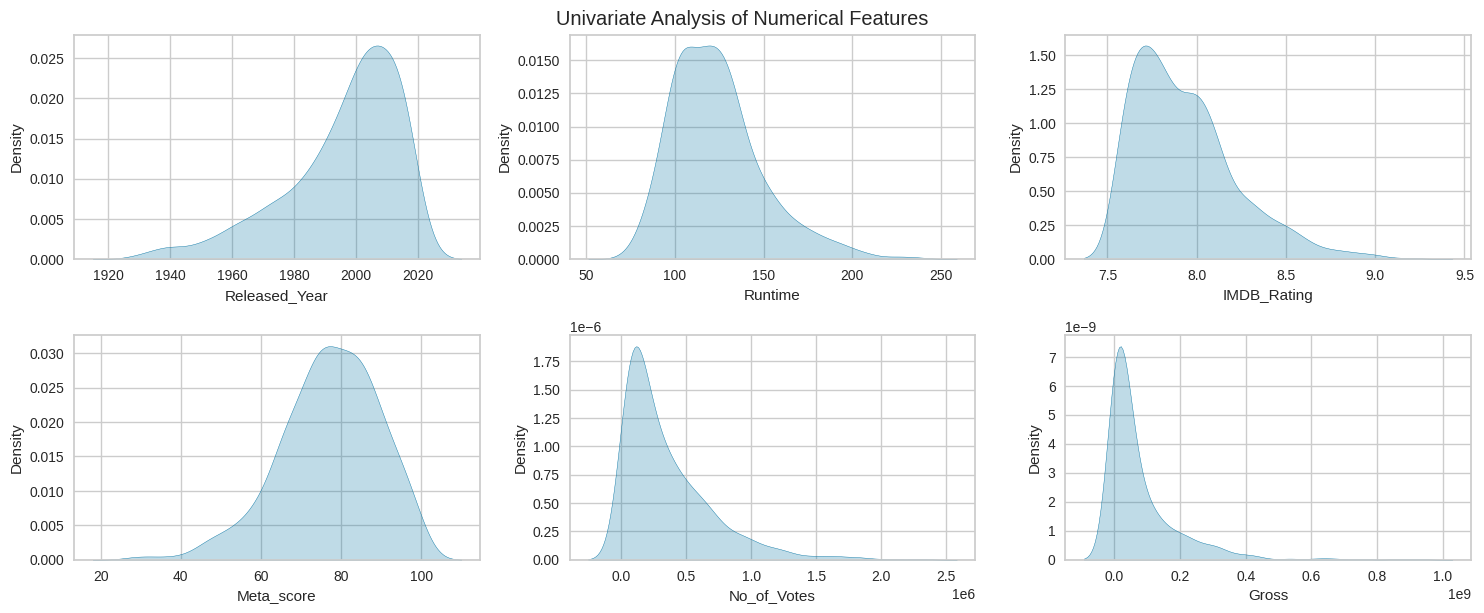

In [129]:
plt.figure(figsize = (15, 15))

plt.suptitle("Univariate Analysis of Numerical Features")

for i in range(len(numerical_features)):
  plt.subplot(5, 3, i+1)
  sns.kdeplot(dados[numerical_features[i]], fill = True)
  plt.xlabel(numerical_features[i])
  plt.tight_layout()

Observando os gráficos, chegamos a algumas conlusões:
* Sim, como o análise com o método describe() já apontava, há variáveis com outliers, especialmente **Gross**, que apresenta valores discrepantes mais altos, sinalizando que há produções de faturamento altíssimo, fora do normal, nesta base de dados.
* **Meta-score** já tende a um movimento contrário do da variável **Gross**, pois os valores mais raros são os mais baixos. Isso indica que a visão da crítica especializada sobre esses filmes tende a ser mais positiva do que negativa.
* Embora tenham médias parecidas, os valores mais altos são os mais raros quando analisamos a curva das notas dadas pelo público geral. Aparentemente, os usuários das plataformas tendem a ser menos generesos em suas avaliações do que a crítica especializada, a julgar pela variável **IMDB_Rating**.
* Como esperado, a maior parte dos filmes foram lançados recentemente. Há poucos clássicos das décadas anteriores a 1970.

####Analisando os gráficos de densidade, aparentemente nenhuma variável numérica segue a distribuição normal. Mas, para ter certeza disso, vamos aplicar o teste de Shapiro-Wilk em cada variável numérica. Saber se os dados seguem ou não uma distribuição normal vai ser muito útil para analisarmos a correlação entre essas variáveis, mais à frente.

In [130]:
for feature in numerical_features:
  stat, p_value = stats.shapiro(dados[feature])
  print(f'Variável: {feature}')
  print(f'Estatística do teste: {stat}')
  print(f'p-valor: {p_value:.4f}')

Variável: Released_Year
Estatística do teste: 0.9007404418307574
p-valor: 0.0000
Variável: Runtime
Estatística do teste: 0.9445124824414542
p-valor: 0.0000
Variável: IMDB_Rating
Estatística do teste: 0.9002405653920237
p-valor: 0.0000
Variável: Meta_score
Estatística do teste: 0.9775448480429821
p-valor: 0.0000
Variável: No_of_Votes
Estatística do teste: 0.8162527034907598
p-valor: 0.0000
Variável: Gross
Estatística do teste: 0.6768310685357558
p-valor: 0.0000


#### Como interpretar os resultados do teste?
No teste de Shapiro-Wilk, a hipótese nula é "Os dados seguem uma distribuição normal". Enquanto a hipótese alternativa é: "Os dados NÃO seguem uma distribuição normal".
Considerando um nível de significância de 0.05, caso o p-valor seja igual ou menor que este valor, rejeitamos a hipótese nula.
De acordo com os resultados da aplicação do teste nas variáveis numéricas acima, percebemos que existe forte evidência estatística de que nenhuma delas segue uma distribuição normal. Neste caso, quando analisarmos a correlação entre elas, teremos que optar por um tipo de correlação mais adequado a esses dados.

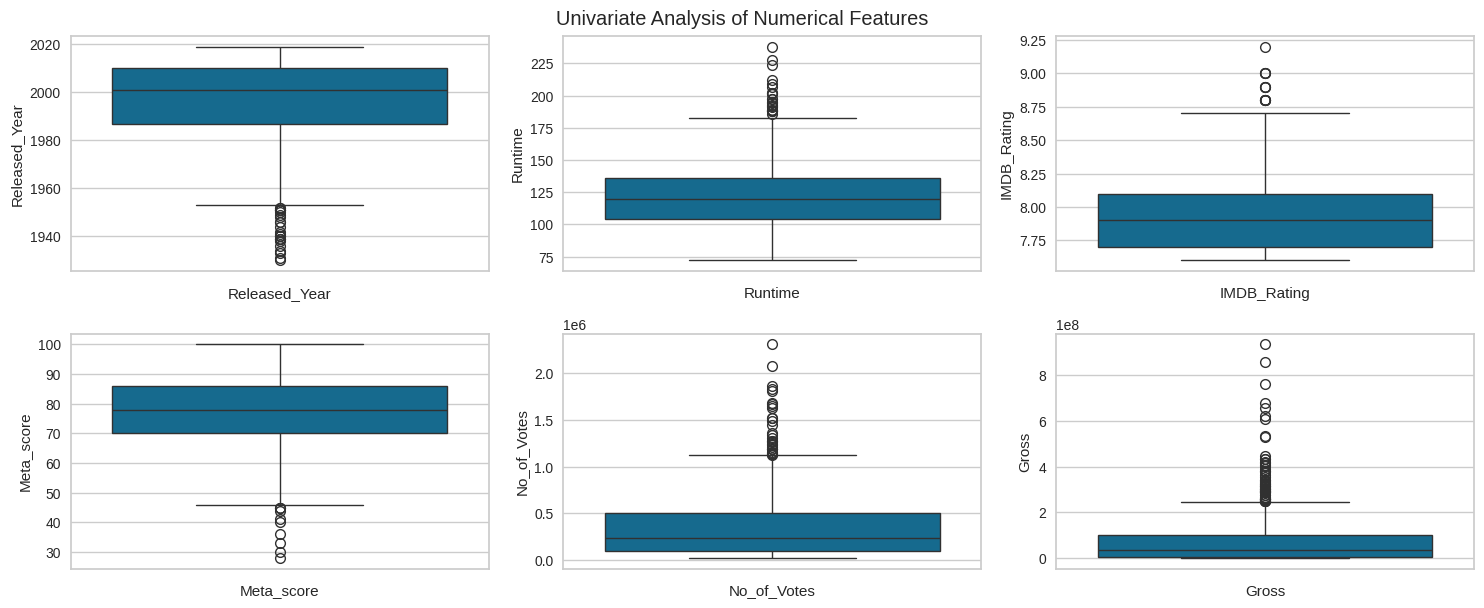

In [131]:
plt.figure(figsize = (15, 15))

plt.suptitle("Univariate Analysis of Numerical Features")

for i in range(len(numerical_features)):
  plt.subplot(5, 3, i+1)
  sns.boxplot(dados[numerical_features[i]], fill = True)
  plt.xlabel(numerical_features[i])
  plt.tight_layout()

Os gráficos de caixa comprovam o que já vinha sendo notado: uma característica dessa base de dados é a quantidade relevante de outliers. É muito importante ter isso em mente porque, ao fim deste percurso analítico, vamos criar um modelo preditivo de ML, e, como sabemos, alguns deles não lidam bem com valores discrepantes.

**Mas o que faremos com os outliers?**

Os valores discrepantes trazem informações muito úteis para a nossa análise sobre os filmes (por exemplo, há diretores que tendem a trabalhar em filmes com altíssimo faturamento?), e simplesmente eliminá-los me parece uma decisão equivocada, pois isso descaracterizaria a base de dados como um todo e nos privaria de informações realistas sobre a indústria cinematográfica. Afinal, é uma indústria diversificada, em que se produzem desde filmes nichados e de baixíssimo faturamento até blockbusters que faturam milhões. Optei por trabalhar com a base de dados desta maneira, com todos os devidos outliers. Só é preciso ter em mente que métricas como a *média*, sensíveis aos outliers, não devem ser muito utilizadas neste caso, optando-se por outras, como a *mediana*.

E uma observação que não foi feita antes: no caso de **Runtime**, os outliers representam os filmes com duração mais longa. Não há nenhum filme com duração mais curta que o normal.

##Análise univariada das variáveis categóricas

In [132]:
categorical_features = dados.select_dtypes(exclude='number').columns
categorical_features

Index(['Series_Title', 'Certificate', 'Genre', 'Overview', 'Director', 'Star1',
       'Star2', 'Star3', 'Star4'],
      dtype='object')

In [133]:
dados['Certificate'].unique()

array(['A', 'UA', 'U', 'R', 'G', 'PG-13', 'PG', 'Passed', 'Approved',
       'TV-PG', 'U/A', 'GP'], dtype=object)

In [134]:
dados['Genre'].unique()

array(['Crime, Drama', 'Action, Crime, Drama', 'Action, Adventure, Drama',
       'Biography, Drama, History', 'Action, Adventure, Sci-Fi', 'Drama',
       'Drama, Romance', 'Western', 'Action, Sci-Fi',
       'Biography, Crime, Drama', 'Action, Adventure, Fantasy',
       'Comedy, Drama, Thriller', 'Adventure, Drama, Sci-Fi',
       'Animation, Adventure, Family', 'Drama, War',
       'Crime, Drama, Fantasy', 'Comedy, Drama, Romance',
       'Crime, Drama, Mystery', 'Crime, Drama, Thriller', 'Drama, Music',
       'Biography, Comedy, Drama', 'Drama, Mystery, Sci-Fi',
       'Biography, Drama, Music', 'Crime, Mystery, Thriller',
       'Animation, Adventure, Drama', 'Adventure, Comedy, Sci-Fi',
       'Horror, Mystery, Thriller', 'Drama, Romance, War',
       'Comedy, Drama, Family', 'Animation, Drama, Fantasy',
       'Animation, Action, Adventure', 'Drama, Western',
       'Action, Adventure', 'Comedy, Drama', 'Drama, Mystery, Thriller',
       'Action, Drama, Mystery', 'Mystery, Thr

#### Para termos uma noção mais clara da distribuição dos filmes de acordo com a duração deles (em minutos), vamos criar uma nova coluna no dataframe contendo 3 classes:
* Short: para filmes com duração menor ou igual a 120 minutos.
* Medium: para filmes com duração entre 121 e 150 minutos.
* Long: para filmes com duração maior que 150 minutos.


Para isso, vamos montar a função classify_duration(), com uma estrutura condicional.

In [135]:
def classify_duration(number):
  if number <= 120:
    return 'short'
  elif number <= 150:
    return 'medium'
  else:
    return 'long'

In [136]:
#aplicando a função a todas as instâncias da coluna "Runtime", com a função "apply()"
dados['Duration_Class'] = dados['Runtime'].apply(classify_duration)


/tmp/ipython-input-3634539209.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = dados, x = 'Duration_Class', palette = 'ocean', order = order)


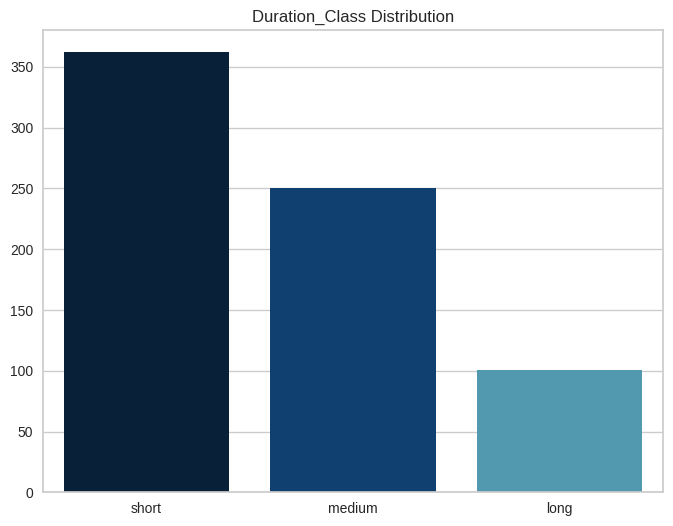

In [137]:
plt.figure(figsize = (8,6))
order = dados['Duration_Class'].value_counts().sort_values(ascending=False).index
sns.countplot(data = dados, x = 'Duration_Class', palette = 'ocean', order = order)
plt.title('Duration_Class Distribution')
plt.xlabel('')
plt.ylabel('')
plt.show();

#### Vemos que a maior parte dos filmes deste conjunto de dados tem duração menor ou igual a 120 min.

/tmp/ipython-input-2793499778.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = dados, x = 'Certificate', palette = 'ocean', order = order)


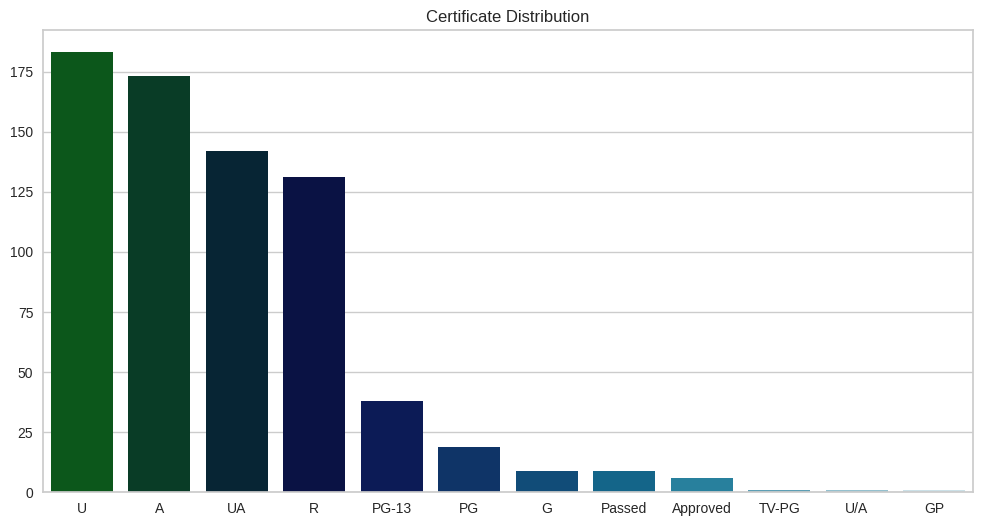

In [138]:
plt.figure(figsize = (12,6))
order = dados['Certificate'].value_counts().sort_values(ascending=False).index
sns.countplot(data = dados, x = 'Certificate', palette = 'ocean', order = order)
plt.title('Certificate Distribution')
plt.xlabel('')
plt.ylabel('')
plt.show();

#### Analisando a distribuição da variável com as classificações etárias, nota-se que ela traz uma quantidade grande de categorias, muitas não tão relevantes para a nossa análise, pois representam relativamente poucos dados. Para facilitar nossas análises daqui para frente, e já pensando em como transformar as variáveis para melhor atender o modelo preditivo que construiremos, vamos reduzir a quantidade de classes desse atributo.

####As duas primeiras linhas de código a seguir listam as classes que vamos manter, que são as mais relevantes (A (Adult), UA (Unrestricted Public Exhibition - but with a word of caution), U (Unrestricted) e R (Restricted)) e substituem as diferentes destas por "Other".

/tmp/ipython-input-382143606.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = dados, x = 'Certificate', palette = 'ocean', order = order)


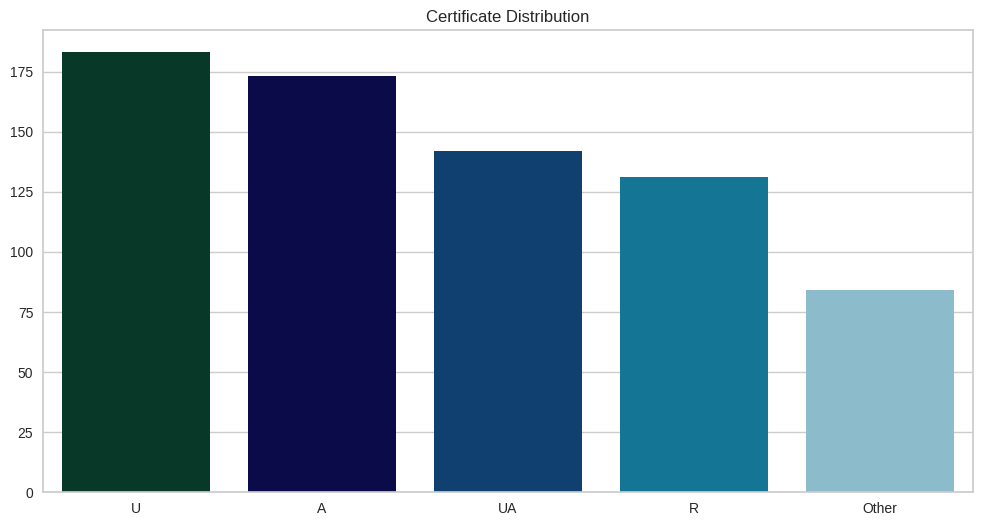

In [139]:
classes = ['A', 'UA', 'U', 'R']
dados['Certificate'] = np.where(dados['Certificate'].isin(classes), dados['Certificate'], 'Other')

plt.figure(figsize = (12,6))
dados.drop(columns='Certificate')
order = dados['Certificate'].value_counts().sort_values(ascending=False).index
sns.countplot(data = dados, x = 'Certificate', palette = 'ocean', order = order)
plt.title('Certificate Distribution')
plt.xlabel('')
plt.ylabel('')
plt.show();

#Qual filme você recomendaria para uma pessoa que você não conhece?


#### Vamos explorar os filmes mais populares da base de dados, definindo o grau de popularidade de acordo com a quantidade de votos recebida. Quanto maior o número de votos, mais popular é o filme.

In [140]:
dados.sort_values("No_of_Votes", ascending = False).head(10)

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Duration_Class
1,The Dark Knight,2008,UA,152,"Action, Crime, Drama",9.00,When the menace known as the Joker wreaks havo...,84.00,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.00,long
7,Inception,2010,UA,148,"Action, Adventure, Sci-Fi",8.80,A thief who steals corporate secrets through t...,74.00,Christopher Nolan,Leonardo DiCaprio,Joseph Gordon-Levitt,Elliot Page,Ken Watanabe,2067042,292576195.00,medium
8,Fight Club,1999,A,139,Drama,8.80,An insomniac office worker and a devil-may-car...,66.00,David Fincher,Brad Pitt,Edward Norton,Meat Loaf,Zach Grenier,1854740,37030102.00,medium
5,Pulp Fiction,1994,A,154,"Crime, Drama",8.90,"The lives of two mob hitmen, a boxer, a gangst...",94.00,Quentin Tarantino,John Travolta,Uma Thurman,Samuel L. Jackson,Bruce Willis,1826188,107928762.00,long
10,Forrest Gump,1994,UA,142,"Drama, Romance",8.80,"The presidencies of Kennedy and Johnson, the e...",82.00,Robert Zemeckis,Tom Hanks,Robin Wright,Gary Sinise,Sally Field,1809221,330252182.00,medium
13,The Matrix,1999,A,136,"Action, Sci-Fi",8.70,When a beautiful stranger leads computer hacke...,73.00,Lana Wachowski,Lilly Wachowski,Keanu Reeves,Laurence Fishburne,Carrie-Anne Moss,1676426,171479930.00,medium
9,The Lord of the Rings: The Fellowship of the Ring,2001,U,178,"Action, Adventure, Drama",8.80,A meek Hobbit from the Shire and eight compani...,92.00,Peter Jackson,Elijah Wood,Ian McKellen,Orlando Bloom,Sean Bean,1661481,315544750.00,long
4,The Lord of the Rings: The Return of the King,2003,U,201,"Action, Adventure, Drama",8.90,Gandalf and Aragorn lead the World of Men agai...,94.00,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,377845905.00,long
0,The Godfather,1972,A,175,"Crime, Drama",9.20,An organized crime dynasty's aging patriarch t...,100.00,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.00,long
62,The Dark Knight Rises,2012,UA,164,"Action, Adventure",8.40,Eight years after the Joker's reign of anarchy...,78.00,Christopher Nolan,Christian Bale,Tom Hardy,Anne Hathaway,Gary Oldman,1516346,448139099.00,long


#### Baseado na análise dos 10 filmes mais votados na plataforma, eu recomendaria o filme The Dark Night, porque recebeu uma nota muito alta dos usuários da plataforma (9.0) e foi bem avaliado também pela crítica e a mídia especializada (dado indicado pela coluna Meta_score), que atribuiu a nota 84 a esta obra. Eu poderia ter escolhido The Godfather, que fez ainda mais sucesso entre os usuários da plataforma e a crítica (recebendo as admiráveis notas 9.2 e 100), porém a classificação etária deste filme é mais restrita (apenas para adultos), e como não conheço a pessoa para a qual estou fazendo a recomendação, é mais prudente escolher um filme com uma classificação etária mais abrangente.

###A variável **Genre**
Em uma cécula anterior, constatamos que esta coluna traz uma quantidade imensa de valores únicos. Para facilitar as nossas análises (e, claro, sempre pensando em que tratamento podemos fazer nas variáveis para aplicá-las ao modelo posteriormente), vamos agrupar gêneros correlacionados. Assim, reduziremos a quantidade de valores únicos neste atributo.

In [141]:
dados['Genre_split'] = dados['Genre'].apply(lambda x: [genre.strip() for genre in x.split(',')])

In [142]:
dados.head(2)

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Duration_Class,Genre_split
0,The Godfather,1972,A,175,"Crime, Drama",9.20,An organized crime dynasty's aging patriarch t...,100.00,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.00,long,"[Crime, Drama]"
1,The Dark Knight,2008,UA,152,"Action, Crime, Drama",9.00,When the menace known as the Joker wreaks havo...,84.00,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.00,long,"[Action, Crime, Drama]"


In [143]:
dados_exploded = dados.explode('Genre_split')

In [144]:
dados_exploded.head(5)

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Duration_Class,Genre_split
0,The Godfather,1972,A,175,"Crime, Drama",9.20,An organized crime dynasty's aging patriarch t...,100.00,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.00,long,Crime
0,The Godfather,1972,A,175,"Crime, Drama",9.20,An organized crime dynasty's aging patriarch t...,100.00,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.00,long,Drama
1,The Dark Knight,2008,UA,152,"Action, Crime, Drama",9.00,When the menace known as the Joker wreaks havo...,84.00,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.00,long,Action
1,The Dark Knight,2008,UA,152,"Action, Crime, Drama",9.00,When the menace known as the Joker wreaks havo...,84.00,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.00,long,Crime
1,The Dark Knight,2008,UA,152,"Action, Crime, Drama",9.00,When the menace known as the Joker wreaks havo...,84.00,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.00,long,Drama


In [145]:
dados_exploded['Genre_split'].unique()

array(['Crime', 'Drama', 'Action', 'Adventure', 'Biography', 'History',
       'Sci-Fi', 'Romance', 'Western', 'Fantasy', 'Comedy', 'Thriller',
       'Animation', 'Family', 'War', 'Mystery', 'Music', 'Horror',
       'Sport', 'Musical', 'Film-Noir'], dtype=object)

In [146]:
dados_exploded.query("Genre_split == 'Sport'")

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Duration_Class,Genre_split
99,Bacheha-Ye aseman,1997,Other,89,"Drama, Family, Sport",8.30,"After a boy loses his sister's pair of shoes, ...",77.00,Majid Majidi,Mohammad Amir Naji,Amir Farrokh Hashemian,Bahare Seddiqi,Nafise Jafar-Mohammadi,65341,933933.00,short,Sport
143,Warrior,2011,UA,140,"Action, Drama, Sport",8.20,The youngest son of an alcoholic former boxer ...,71.00,Gavin O'Connor,Tom Hardy,Nick Nolte,Joel Edgerton,Jennifer Morrison,435950,13657115.00,medium,Sport
147,Chak De! India,2007,U,153,"Drama, Family, Sport",8.20,Kabir Khan is the coach of the Indian Women's ...,68.00,Shimit Amin,Shah Rukh Khan,Vidya Malvade,Sagarika Ghatge,Shilpa Shukla,74129,1113541.00,long,Sport
172,Raging Bull,1980,A,129,"Biography, Drama, Sport",8.20,"The life of boxer Jake LaMotta, whose violence...",89.00,Martin Scorsese,Robert De Niro,Cathy Moriarty,Joe Pesci,Frank Vincent,321860,23383987.00,medium,Sport
233,Million Dollar Baby,2004,UA,132,"Drama, Sport",8.10,A determined woman works with a hardened boxin...,86.00,Clint Eastwood,Hilary Swank,Clint Eastwood,Morgan Freeman,Jay Baruchel,635975,100492203.00,medium,Sport
251,The Big Lebowski,1998,R,117,"Comedy, Crime, Sport",8.10,"Jeff ""The Dude"" Lebowski, mistaken for a milli...",71.00,Joel Coen,Ethan Coen,Jeff Bridges,John Goodman,Julianne Moore,732620,17498804.00,short,Sport
278,Rocky,1976,U,120,"Drama, Sport",8.10,A small-time boxer gets a supremely rare chanc...,70.00,John G. Avildsen,Sylvester Stallone,Talia Shire,Burt Young,Carl Weathers,518546,117235247.00,short,Sport
433,The Hustler,1961,A,134,"Drama, Sport",8.00,An up-and-coming pool player plays a long-time...,90.00,Robert Rossen,Paul Newman,Jackie Gleason,Piper Laurie,George C. Scott,75067,8284000.00,medium,Sport
488,The Wrestler,2008,UA,109,"Drama, Sport",7.90,"A faded professional wrestler must retire, but...",80.00,Darren Aronofsky,Mickey Rourke,Marisa Tomei,Evan Rachel Wood,Mark Margolis,289415,26236603.00,short,Sport
613,The Fighter,2010,UA,116,"Biography, Drama, Sport",7.80,"Based on the story of Micky Ward, a fledgling ...",79.00,David O. Russell,Mark Wahlberg,Christian Bale,Amy Adams,Melissa Leo,340584,93617009.00,short,Sport



Analisando somente os filmes classificados no gênero "Sport", percebemos que todos eles também foram classificados no gênero "Drama". Então a classe "Sport" será incluída do grupo "Drama, History", que criaremos a seguir.

#### Vamos agrupar alguns desses gêneros, para reduzirmos a redundância e facilitarmos a análise (por exemplo, "music" e "musical" querem dizer quase a mesma coisa...). Para isso vamos usar o método **.map()**.

In [147]:
#criando um dicionário com os grupos novos e quais classes pertencerão aos devidos grupos
mapping_genres = {'Action': 'Action, Adventure',
    'Adventure': 'Action, Adventure',
    'Western': 'Action, Adventure',
    'War': 'Action, Adventure',

    'Thriller': 'Thriller, Mystery, Horror',
    'Mystery': 'Thriller, Mystery, Horror',
    'Film-Noir': 'Thriller, Mystery, Horror',
    'Horror': 'Thriller, Mystery, Horror',

    'Drama': 'Drama, History',
    'Biography': 'Drama, History',
    'History': 'Drama, History',
    'Sport': 'Drama, History',

    'Sci-Fi': 'Fantasy, Sci-Fi',
    'Fantasy': 'Fantasy, Sci-Fi',

    'Animation': 'Animation, Family',
    'Family': 'Animation, Family',

    'Music': 'Musical',
    'Musical': 'Musical'}


In [148]:
dados_exploded['Genres_regrouped'] = dados_exploded['Genre_split'].map(mapping_genres)
dados_exploded['Genres_regrouped'].fillna(dados_exploded['Genre_split'], inplace=True)

/tmp/ipython-input-2592324481.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dados_exploded['Genres_regrouped'].fillna(dados_exploded['Genre_split'], inplace=True)


In [149]:
dados_exploded.head()

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Duration_Class,Genre_split,Genres_regrouped
0,The Godfather,1972,A,175,"Crime, Drama",9.20,An organized crime dynasty's aging patriarch t...,100.00,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.00,long,Crime,Crime
0,The Godfather,1972,A,175,"Crime, Drama",9.20,An organized crime dynasty's aging patriarch t...,100.00,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.00,long,Drama,"Drama, History"
1,The Dark Knight,2008,UA,152,"Action, Crime, Drama",9.00,When the menace known as the Joker wreaks havo...,84.00,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.00,long,Action,"Action, Adventure"
1,The Dark Knight,2008,UA,152,"Action, Crime, Drama",9.00,When the menace known as the Joker wreaks havo...,84.00,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.00,long,Crime,Crime
1,The Dark Knight,2008,UA,152,"Action, Crime, Drama",9.00,When the menace known as the Joker wreaks havo...,84.00,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.00,long,Drama,"Drama, History"


In [150]:
dados_exploded['Genres_regrouped'].unique()

array(['Crime', 'Drama, History', 'Action, Adventure', 'Fantasy, Sci-Fi',
       'Romance', 'Comedy', 'Thriller, Mystery, Horror',
       'Animation, Family', 'Musical'], dtype=object)

In [151]:
dados_exploded = dados_exploded.drop(columns=['Genre', 'Genre_split'])


/tmp/ipython-input-2814379254.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = dados_exploded, x = 'Genres_regrouped', palette = 'ocean', order = order)


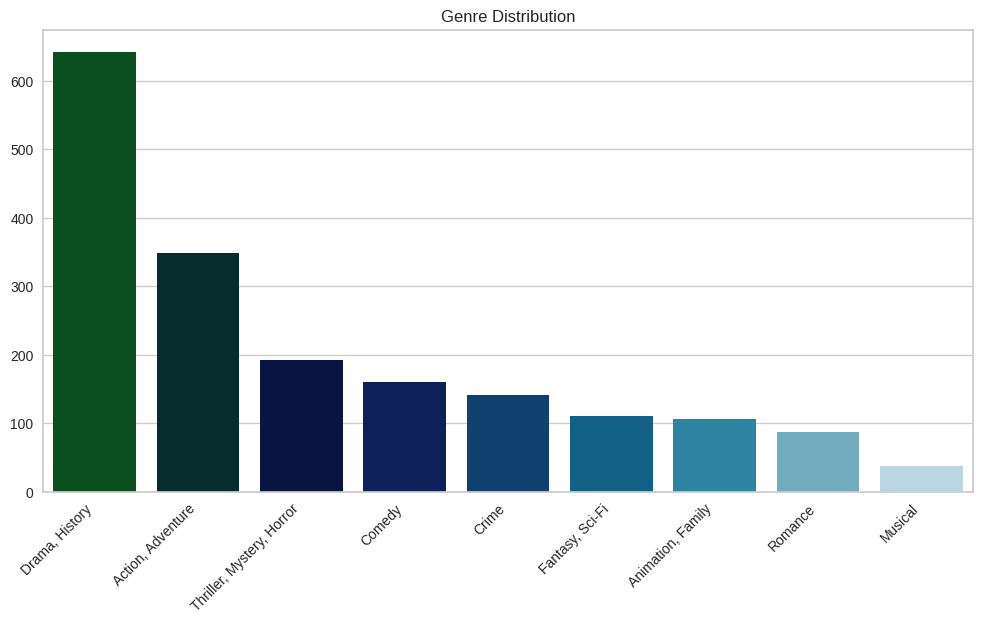

In [152]:
plt.figure(figsize = (12,6))
order = dados_exploded['Genres_regrouped'].value_counts().sort_values(ascending=False).index
sns.countplot(data = dados_exploded, x = 'Genres_regrouped', palette = 'ocean', order = order)
plt.title('Genre Distribution')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45, ha='right')
plt.show();

A maior parte dos filmes são do gênero "Drama, History", e a menor parte pertence ao gênero "Musical".

##Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme?

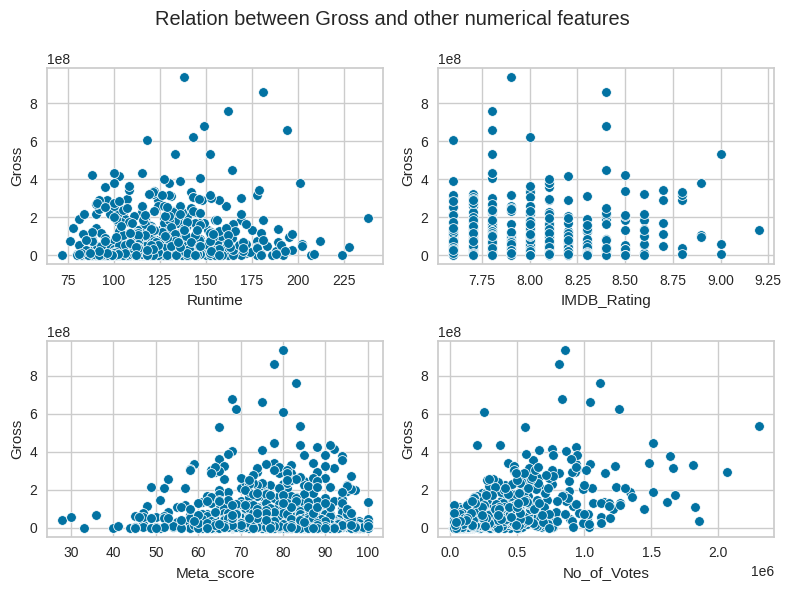

In [153]:
numerical_features1 = ['Runtime','IMDB_Rating', 'Meta_score', 'No_of_Votes']
plt.figure(figsize = (8, 6))

plt.suptitle("Relation between Gross and other numerical features")

for i in range(len(numerical_features1)):
  plt.subplot(2, 2, i+1)
  sns.scatterplot(y = dados['Gross'], x = dados[numerical_features1[i]])
  plt.xlabel(numerical_features1[i])

plt.tight_layout()

Pelos gráficos de dispersão, não parece haver relação de linearidade entre o faturamento e o número de votos, as notas dadas pelo público geral e pela crítica ou a duração do filme.

Vamos ver se conseguimos perceber uma relação mais linear se restringirmos o grupo analisado. Desta vez, vamos considerar apenas os filmes com faturamento bem alto, aqueles que faturaram mais do que 75% dos filmes faturaram.

In [154]:
high_gross = dados['Gross'].quantile(0.75)
print(f'O valor de corte que consideraremos nesta análise é o faturamento de {high_gross}')

O valor de corte que consideraremos nesta análise é o faturamento de 102515793.0


In [155]:
data_high_gross_movies = dados[dados['Gross'] > high_gross]
display(data_high_gross_movies.head(5))
display(data_high_gross_movies.shape)

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Duration_Class,Genre_split
0,The Godfather,1972,A,175,"Crime, Drama",9.20,An organized crime dynasty's aging patriarch t...,100.00,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.00,long,"[Crime, Drama]"
1,The Dark Knight,2008,UA,152,"Action, Crime, Drama",9.00,When the menace known as the Joker wreaks havo...,84.00,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.00,long,"[Action, Crime, Drama]"
4,The Lord of the Rings: The Return of the King,2003,U,201,"Action, Adventure, Drama",8.90,Gandalf and Aragorn lead the World of Men agai...,94.00,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,377845905.00,long,"[Action, Adventure, Drama]"
5,Pulp Fiction,1994,A,154,"Crime, Drama",8.90,"The lives of two mob hitmen, a boxer, a gangst...",94.00,Quentin Tarantino,John Travolta,Uma Thurman,Samuel L. Jackson,Bruce Willis,1826188,107928762.00,long,"[Crime, Drama]"
7,Inception,2010,UA,148,"Action, Adventure, Sci-Fi",8.80,A thief who steals corporate secrets through t...,74.00,Christopher Nolan,Leonardo DiCaprio,Joseph Gordon-Levitt,Elliot Page,Ken Watanabe,2067042,292576195.00,medium,"[Action, Adventure, Sci-Fi]"


(178, 17)

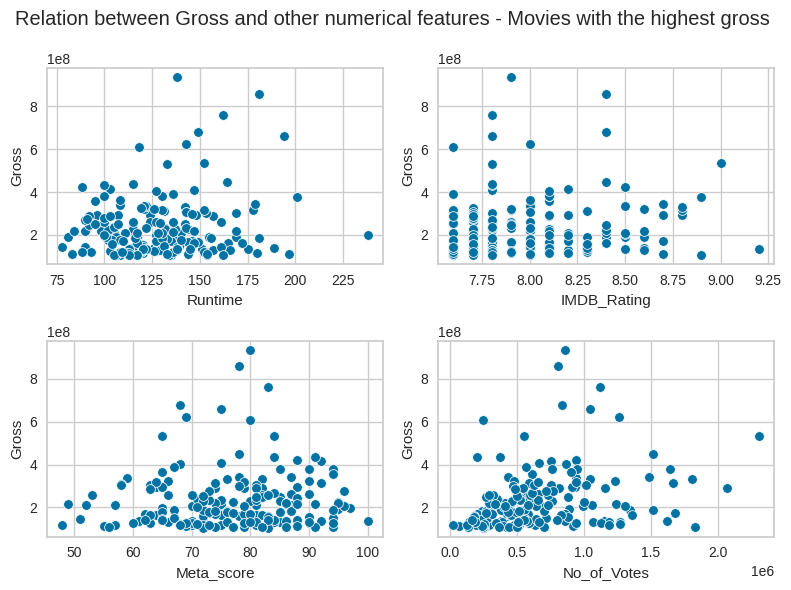

In [156]:
numerical_features1 = ['Runtime','IMDB_Rating', 'Meta_score', 'No_of_Votes']
plt.figure(figsize = (8, 6))

plt.suptitle("Relation between Gross and other numerical features - Movies with the highest gross")

for i in range(len(numerical_features1)):
  plt.subplot(2, 2, i+1)
  sns.scatterplot(y = data_high_gross_movies['Gross'], x = data_high_gross_movies[numerical_features1[i]])
  plt.xlabel(numerical_features1[i])

plt.tight_layout()

Bem, percebemos que mesmo focando apenas nos faturamentos mais altos, a relação de linearidade é muito fraca entre essas variáveis. Não podemos afirmar, por exemplo, que a duração do filme é um fator que impacta significativamente o faturamento do filme.

Agora vamos analisar a relação dessas variáveis numéricas usando a métrica da correlação de Spearman (o tipo de correlação adequado para uma distribuição não-paramétrica, cujos dados não seguem uma distribuição normal).

In [157]:
numerical_features = ['Gross', 'No_of_Votes', 'Meta_score', 'Runtime', 'IMDB_Rating']

corr_spearman = data_high_gross_movies[numerical_features].corr(method='spearman')

print(corr_spearman)

             Gross  No_of_Votes  Meta_score  Runtime  IMDB_Rating
Gross         1.00         0.36        0.07     0.02         0.14
No_of_Votes   0.36         1.00        0.11     0.26         0.65
Meta_score    0.07         0.11        1.00    -0.17         0.25
Runtime       0.02         0.26       -0.17     1.00         0.19
IMDB_Rating   0.14         0.65        0.25     0.19         1.00


#### Observações:
####* Curiosamente, a matriz de correlação mostra uma relação fraca entre as variáveis **Meta-score** e **IMDB_Rating**, mostrando que há divergência entre a nota dada pela crítica especializada e a nota dada pelo público geral.

####* Também percebemos que nenhuma das variáveis numéricas parecem ter impacto relevante na variável **Gross**, portanto aparentemente o faturamento não pode ser explicado pelas notas recebidas, pelo número de votos contabilizados e a duração do filme.

### Será que determinadas classificações etárias apresentam faturamento maior?

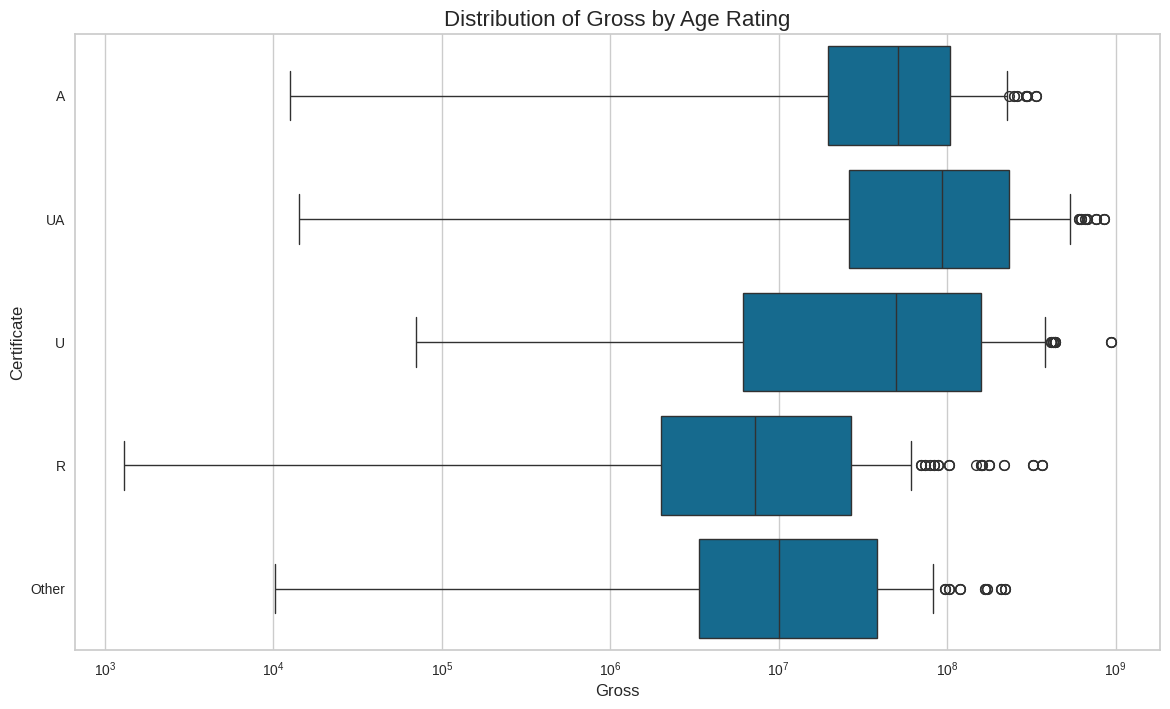

In [158]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=dados_exploded, x='Gross', y='Certificate')

plt.title('Distribution of Gross by Age Rating', fontsize=16)
plt.xlabel('Gross', fontsize=12)
plt.ylabel('Certificate', fontsize=12)
# Usar escala de log no eixo x é crucial para uma boa visualização
plt.xscale('log')

plt.show()

Aparentemente, filmes com faturamentos altos tendem a ser classificados como UA: é o que aponta a mediana da caixa correspondente a esta classificação no gráfico. Quando comparada às caixas das outras classificações, UA é a que concentra filmes com faturamentos maiores.

### Será que o gênero impacta no faturamento do filme?

In [159]:
dados_exploded.columns

Index(['Series_Title', 'Released_Year', 'Certificate', 'Runtime',
       'IMDB_Rating', 'Overview', 'Meta_score', 'Director', 'Star1', 'Star2',
       'Star3', 'Star4', 'No_of_Votes', 'Gross', 'Duration_Class',
       'Genres_regrouped'],
      dtype='object')

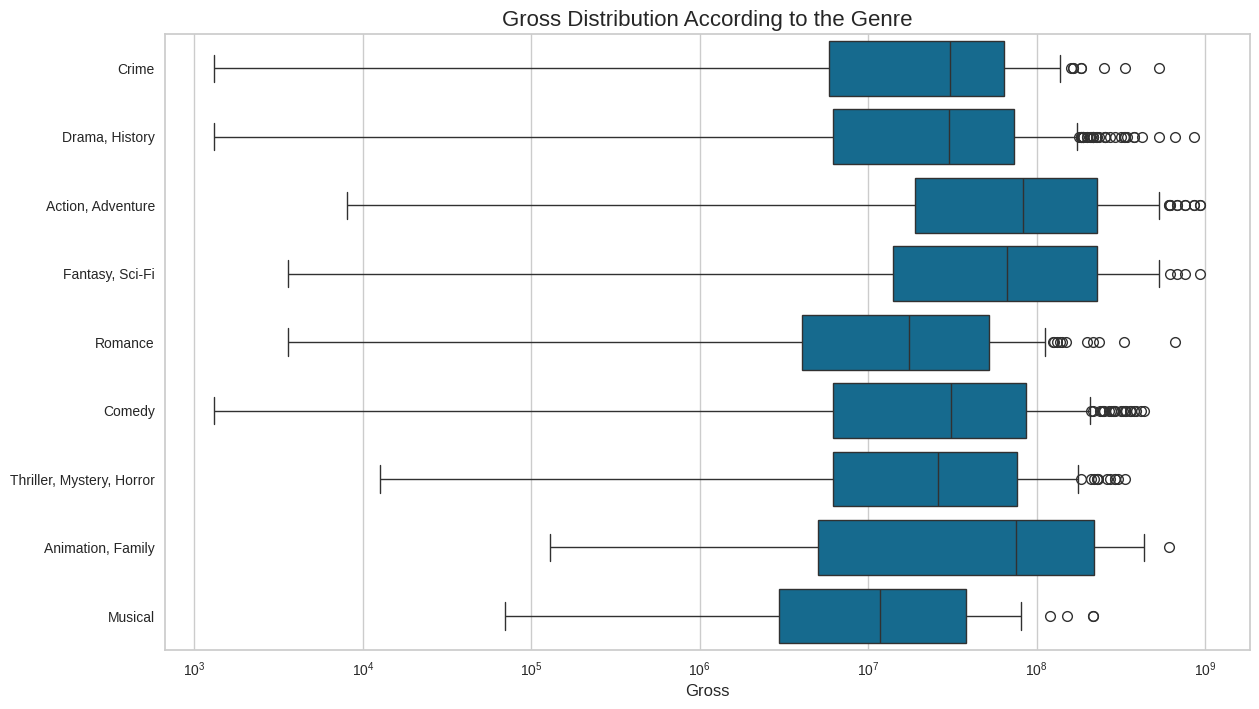

In [160]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=dados_exploded, x='Gross', y='Genres_regrouped')

plt.title('Gross Distribution According to the Genre', fontsize=16)
plt.xlabel('Gross', fontsize=12)
plt.ylabel('')
# Usar escala de log no eixo x é crucial para uma boa visualização
plt.xscale('log')

plt.show()

Pelos gráficos, vemos que os filmes de ação e aventura são os mais bem-sucedidos em termos de bilheteria.

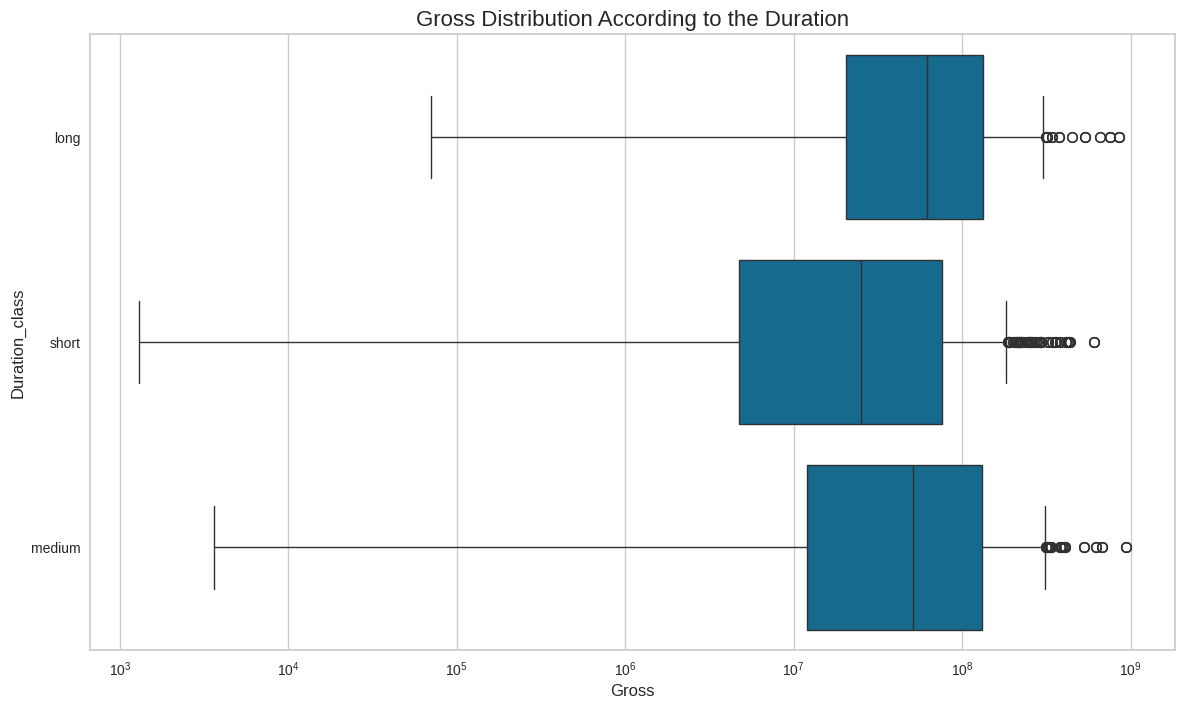

In [161]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=dados_exploded, x='Gross', y='Duration_Class')

plt.title('Gross Distribution According to the Duration', fontsize=16)
plt.xlabel('Gross', fontsize=12)
plt.ylabel('Duration_class', fontsize=12)
# Usar escala de log no eixo x é crucial para uma boa visualização
plt.xscale('log')

plt.show()

Quando avaliamos as categorias de duração, há quase um empate entre filmes longos e filmes médios, no quesito maior faturamento.

### Por último, vamos descobrir se há diretores que predominantemente trabalham em filmes de alto faturamento.

Vamos considerar os 25% de filmes com maior faturamento desta base de dados e ver que diretores trabalham em mais filmes nesta faixa "privilegiada" de nosso dataset.

In [162]:
terceiro_quartil = dados_exploded['Gross'].quantile(0.75)

print(f"O faturamento do terceiro quartil (top 25%) é: {terceiro_quartil}")

df_top_faturamento = dados_exploded[dados_exploded['Gross'] >= terceiro_quartil]

print(f"\nNúmero de filmes no top 25% de faturamento: {len(df_top_faturamento)}")

diretores_mais_frequentes = df_top_faturamento['Director'].value_counts()


print("\nDiretores que mais aparecem entre os filmes com maior faturamento:")
print(diretores_mais_frequentes.head(10))

O faturamento do terceiro quartil (top 25%) é: 107928762.0

Número de filmes no top 25% de faturamento: 459

Diretores que mais aparecem entre os filmes com maior faturamento:
Director
Steven Spielberg     21
Christopher Nolan    16
Robert Zemeckis      14
Peter Jackson        13
Ridley Scott         12
Anthony Russo        12
Pete Docter           9
James Mangold         9
David Yates           9
Quentin Tarantino     9
Name: count, dtype: int64


Vermos que Steven Spielberg, Christopher Nolan, Robert Zemeckis, Peter Jackson, Anthony Russo e Ridley Scott apresentam mais de 10 filmes nessa faixa de faturamento (que é uma quantidade de filmes sucessos de bilheteria impressionante).

Vamos fazer uma análise um pouco diferente agora: vamos somar o faturamento dos filmes de cada diretor e exibir os top 5 em um gráfico de barras.

Director
Anthony Russo       6615118209.00
Steven Spielberg    5748391894.00
Christopher Nolan   5131825920.00
James Cameron       4342141077.00
J.J. Abrams         4269512715.00
Peter Jackson       4230566906.00
Brad Bird           3298883385.00
David Yates         2936861163.00
Pete Docter         2818146393.00
Robert Zemeckis     2818087186.00
Name: Gross, dtype: float64


/tmp/ipython-input-1425222946.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=faturamento_total_por_diretor.head(5).values, y=faturamento_total_por_diretor.head(5).index, palette='ocean')


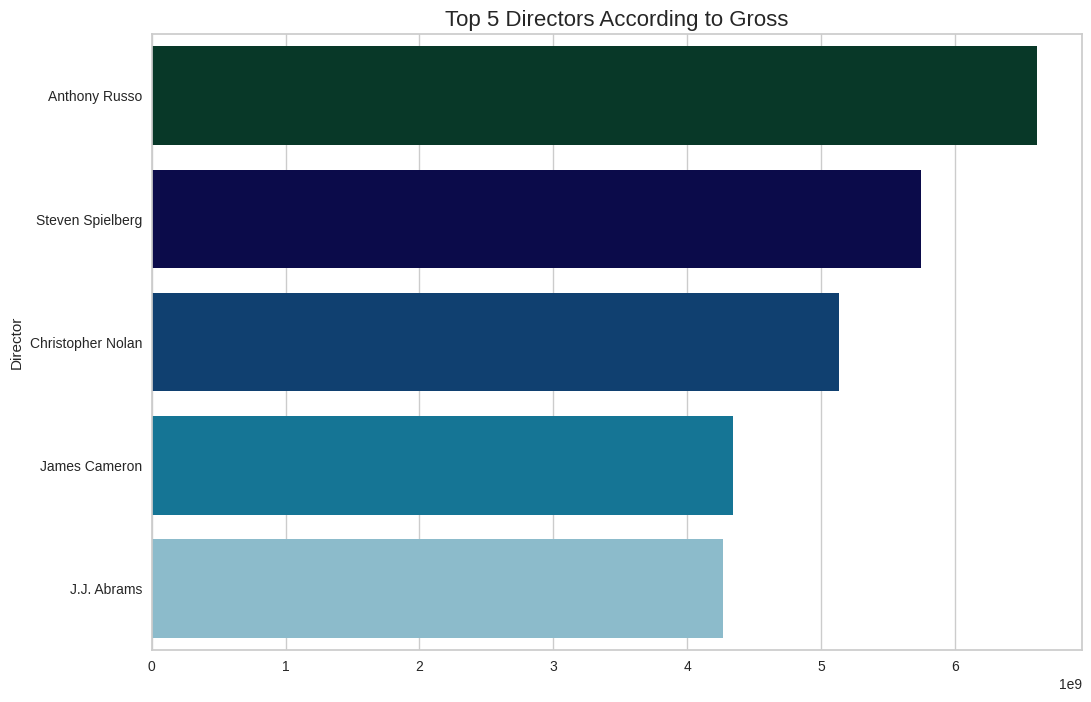

In [163]:
faturamento_total_por_diretor = dados_exploded.groupby('Director')['Gross'].sum().sort_values(ascending=False)

print(faturamento_total_por_diretor.head(10))
plt.figure(figsize=(12, 8))
sns.barplot(x=faturamento_total_por_diretor.head(5).values, y=faturamento_total_por_diretor.head(5).index, palette='ocean')
plt.title('Top 5 Directors According to Gross', fontsize=16)
plt.show()

#### Podemos inferir que filmes longos ou médios, dos gêneros ação ou aventura, de classificação etária UA e dirigidos por determinados diretores, como JJ Abrams, Christopher Nolan, Spielberg e Anthony Russo têm probabilidade mais alta de serem sucesso de bilheteria e renderem um faturamento alto para a produtora de filmes.

## Quais insights podem ser tirados com a coluna Overview? É possível inferir o gênero do filme a partir dessa coluna?


A coluna **Overview** pode nos fornecer muitas informações, para citar algumas:
* se há diferença entre os termos mais utilizados para descrever determinados tipos de filme ao longo dos anos (por exemplo, hoje em dia ainda se usa o termo "Filme noir", como na metade do século passado?);
* quais palavras tendem a se repetir nas sinopses de cada gênero;
* quais gêneros costumam ter uma sinopse mais longa;
* indo um pouco mais além, podemos aplicar a técnica da análise de sentimentos para identificar quais gêneros apresentam uma sinopse mais positiva, mais neutra ou mais negativa. E indo ainda mais além, podemos fazer uma análise das emoções dessas sinopses, definindo as emoções específicas que desejamos identificar.

###Vamos plotar gráficos de nuvens de palavras de alguns gêneros para abordarmos algumas dessas questões. Na pipeline a seguir, os dados textuais da coluna **Overview** serão tratados com os seguintes procedimentos: remoção de ruídos, espaços extras e caracteres que não são textuais; remoção de stopwords, que são palavras irrelevantes, sem muito significado; tokenização. Depois do tratamento, vamos plotar alguns gráficos e responder à questão: é possível inferir o gênero do filme a partir da sinopse?

In [164]:
dados.columns

Index(['Series_Title', 'Released_Year', 'Certificate', 'Runtime', 'Genre',
       'IMDB_Rating', 'Overview', 'Meta_score', 'Director', 'Star1', 'Star2',
       'Star3', 'Star4', 'No_of_Votes', 'Gross', 'Duration_Class',
       'Genre_split'],
      dtype='object')

In [165]:
pip install wordcloud

In [166]:
%matplotlib inline
from wordcloud import WordCloud

In [167]:
#imprimindo a lista de stop words da língua inglesa

stop_words = nltk.corpus.stopwords.words("english")
stop_words

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 'her',
 'here',
 'hers',
 'herself',
 "he's",
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 'if',
 "i'll",
 "i'm",
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 "i've",
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [168]:
def clean_data(data):
  data = str(data).lower() #colocando todas as letras da base em caixa-baixa

  data = re.sub(r"[^a-zA-Z]", " ", data) #removendo caracteres que não sejam letras
  data = re.sub(r"\s+", " ", data) #caso haja espaços extras, vamos substituí-los por um único espaço

  return data

def remove_stop_words(words): #removendo as stopwords
  filter_words = []
  for i in words:
    if i not in stop_words:
      filter_words.append(i)
  return filter_words

In [169]:
data_clean = dados_exploded.copy() #fazendo uma cópia da base de dados original para realizar o tratamento

In [170]:
data_clean['Overview'] = data_clean['Overview'].apply(lambda x: clean_data(x))
data_clean['Overview'][0]

,Overview
0,an organized crime dynasty s aging patriarch t...
0,an organized crime dynasty s aging patriarch t...


In [171]:
data_clean['Overview'] = data_clean['Overview'].apply(lambda x: x.split(" "))

In [172]:
data_clean['Overview'] = data_clean['Overview'].apply(lambda x: remove_stop_words(x))

In [173]:
nlp = spacy.load('en_core_web_sm') #como a base de dados que estamos usando está em inglês, vamos importar este modelo de linguagem da biblioteca spacy
data_clean['Overview'] = data_clean['Overview'].apply(lambda x: [token.lemma_ for token in nlp(" ".join(x))])

In [174]:
data_clean

,Series_Title,Released_Year,Certificate,Runtime,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Duration_Class,Genres_regrouped
0,The Godfather,1972,A,175,9.20,"[organized, crime, dynasty, age, patriarch, tr...",100.00,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.00,long,Crime
0,The Godfather,1972,A,175,9.20,"[organized, crime, dynasty, age, patriarch, tr...",100.00,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.00,long,"Drama, History"
1,The Dark Knight,2008,UA,152,9.00,"[menace, know, joker, wreak, havoc, chaos, peo...",84.00,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.00,long,"Action, Adventure"
1,The Dark Knight,2008,UA,152,9.00,"[menace, know, joker, wreak, havoc, chaos, peo...",84.00,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.00,long,Crime
1,The Dark Knight,2008,UA,152,9.00,"[menace, know, joker, wreak, havoc, chaos, peo...",84.00,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.00,long,"Drama, History"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,A Hard Day's Night,1964,U,87,7.60,"[two, typical, day, life, beatle, boy, struggl...",96.00,Richard Lester,John Lennon,Paul McCartney,George Harrison,Ringo Starr,40351,13780024.00,short,Musical
993,A Hard Day's Night,1964,U,87,7.60,"[two, typical, day, life, beatle, boy, struggl...",96.00,Richard Lester,John Lennon,Paul McCartney,George Harrison,Ringo Starr,40351,13780024.00,short,Musical
996,From Here to Eternity,1953,Other,118,7.60,"[hawaii, private, cruelly, punish, box, unit, ...",85.00,Fred Zinnemann,Burt Lancaster,Montgomery Clift,Deborah Kerr,Donna Reed,43374,30500000.00,short,"Drama, History"
996,From Here to Eternity,1953,Other,118,7.60,"[hawaii, private, cruelly, punish, box, unit, ...",85.00,Fred Zinnemann,Burt Lancaster,Montgomery Clift,Deborah Kerr,Donna Reed,43374,30500000.00,short,Romance


In [175]:
data_clean['Overview'] = data_clean['Overview'].apply(lambda x: ' '.join(x))

In [176]:
data_clean.head(10)

,Series_Title,Released_Year,Certificate,Runtime,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Duration_Class,Genres_regrouped
0,The Godfather,1972,A,175,9.20,organized crime dynasty age patriarch transfer...,100.00,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.00,long,Crime
0,The Godfather,1972,A,175,9.20,organized crime dynasty age patriarch transfer...,100.00,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.00,long,"Drama, History"
1,The Dark Knight,2008,UA,152,9.00,menace know joker wreak havoc chaos people got...,84.00,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.00,long,"Action, Adventure"
1,The Dark Knight,2008,UA,152,9.00,menace know joker wreak havoc chaos people got...,84.00,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.00,long,Crime
1,The Dark Knight,2008,UA,152,9.00,menace know joker wreak havoc chaos people got...,84.00,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.00,long,"Drama, History"
2,The Godfather: Part II,1974,A,202,9.00,early life career vito corleone new york city ...,90.00,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.00,long,Crime
2,The Godfather: Part II,1974,A,202,9.00,early life career vito corleone new york city ...,90.00,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.00,long,"Drama, History"
3,12 Angry Men,1957,U,96,9.00,jury holdout attempt prevent miscarriage justi...,96.00,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000.00,short,Crime
3,12 Angry Men,1957,U,96,9.00,jury holdout attempt prevent miscarriage justi...,96.00,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000.00,short,"Drama, History"
4,The Lord of the Rings: The Return of the King,2003,U,201,8.90,gandalf aragorn lead world man sauron army dra...,94.00,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,377845905.00,long,"Action, Adventure"


In [177]:
grouped_overviews_by_genre = data_clean.groupby('Genres_regrouped')['Overview'].apply(' '.join)

In [178]:
words_crime = grouped_overviews_by_genre['Crime']

<function matplotlib.pyplot.show(close=None, block=None)>

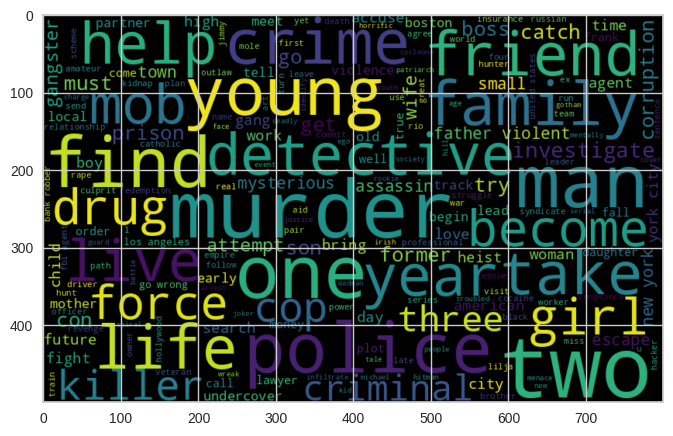

In [179]:
word_cloud = WordCloud(width = 800, height = 500, max_font_size = 110, stopwords={'film', 'movie', 'story'}).generate(words_crime)
plt.figure(figsize = (8,6))
plt.imshow(word_cloud, interpolation='bilinear')
plt.show

###Por exemplo, observa-se que nas sinopses dos filmes do gênero Crime predominam palavras como "murder", "police", "detective", "crime", muito representativas deste gênero.

<function matplotlib.pyplot.show(close=None, block=None)>

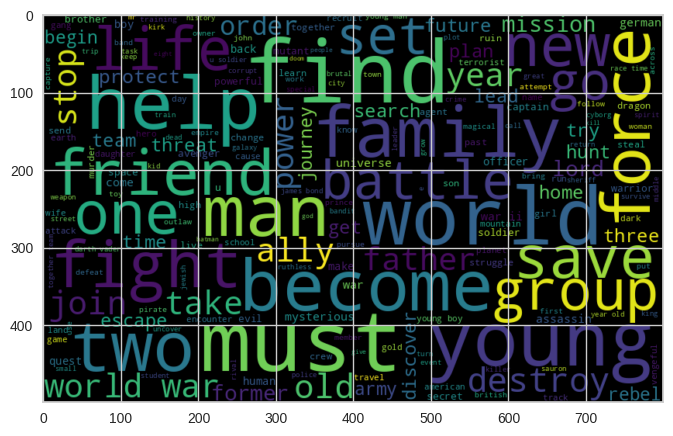

In [180]:
words_action_adventure = grouped_overviews_by_genre['Action, Adventure']
word_cloud = WordCloud(width = 800, height = 500, max_font_size = 110, stopwords={'film', 'movie', 'story'}).generate(words_action_adventure)
plt.figure(figsize = (8,6))
plt.imshow(word_cloud, interpolation='bilinear')
plt.show


####Os filmes de ação e aventura apresentam um vocabulário também mais específico, que abrangem palavras como "world war", "destroy", "force", "battle", diferentes das dos filmes do gênero anterior.

<function matplotlib.pyplot.show(close=None, block=None)>

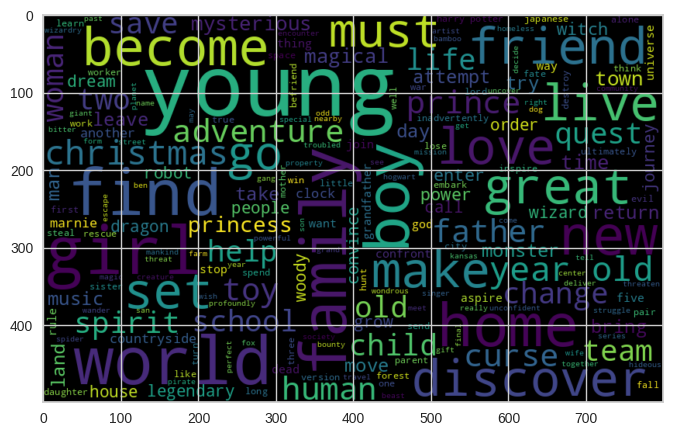

In [181]:
words_animation_family = grouped_overviews_by_genre['Animation, Family']
word_cloud = WordCloud(width = 800, height = 500, max_font_size = 110, stopwords={'film', 'movie', 'story'}).generate(words_animation_family)
plt.figure(figsize = (8,6))
plt.imshow(word_cloud, interpolation='bilinear')
plt.show

####Os filmes para a família apresentam um vocabulário mais infantil e positivo, em comparação com a nuvem de palavras dos gêneros anteriores. Por exemplo: "boy", "girl", "love", "discover", "friend", "school", "great", "toy".

#### Portanto, a coluna **Overview** pode ser uma forte aliada na identificação do gênero dos filmes, sim.

##Explique como você faria a previsão da nota do imdb a partir dos dados. Quais variáveis e/ou suas transformações você utilizou e por quê? Qual tipo de problema estamos resolvendo (regressão, classificação)? Qual modelo melhor se aproxima dos dados e quais seus prós e contras? Qual medida de performance do modelo foi escolhida e por quê?

#### Este é um caso de modelo de regressão, e não de classificação, pois estamos lidando com uma variável-alvo numérica (IMDB_Rating). Utilizamos modelos de regressão quando a variável-alvo é numérica, tanto discreta quanto contínua.

#### Como estamos lidando com uma base de dados que apresenta outliers, precisamos escolher modelos preditivos que não sejam muito sensíveis a estes valores discrepantes. Por exemplo, a clássica regressão linear está fora de questão. Os modelos **árvore de decisão** e **floresta aleatória** são boas opções neste caso, pois não são sensíveis a outliers.

Antes de tudo, vamos separar os dados em 3 conjuntos:
* Conjunto de treino (utilizado para treinar o modelo)
* Conjunto de validação (para avaliar o modelo e ajustar os hiperparâmetros)
* Conjunto de teste (para fazer a avaliação final)

In [182]:
from sklearn.model_selection import train_test_split

In [183]:
X = dados_exploded.drop(['IMDB_Rating', 'Series_Title', 'Overview'], axis = 1)
y = dados_exploded['IMDB_Rating']

In [184]:
#Separando 20% dos dados para teste
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

In [185]:
#20% já foram separados para teste, então temos os 80% restantes para dividir entre validação e treino.
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size = 0.25, random_state = 8)

### Pré-processamento dos dados de treino

In [186]:
X_train.columns

Index(['Released_Year', 'Certificate', 'Runtime', 'Meta_score', 'Director',
       'Star1', 'Star2', 'Star3', 'Star4', 'No_of_Votes', 'Gross',
       'Duration_Class', 'Genres_regrouped'],
      dtype='object')

#### Engenharia de Features

Como vamos precisar **obrigatoriamente** transformar as variáveis categóricas em numéricas, aplicando a técnica do **One-Hot Encoding**, para que os modelos preditivos consigam processar os dados do dataset, variáveis com um número gigantesco de classes únicas, como **Star1** e **Director** serão eliminadas, pois elas gerariam um número muito grande de colunas, na base tratada. Mas por que isso seria prejudicial? Um número muito grande de colunas, ou seja, de variáveis explicativas, torna o modelo muito complexo e propenso à overfitting.

In [187]:
#eliminando colunas que não serão utilizadas na construção dos modelos preditivos
X_train = X_train.drop(['Duration_Class', 'Director', 'Star1', 'Star2',
       'Star3', 'Star4'], axis = 1)

###Transformando dados categóricos em numéricos

In [188]:
cat_features = X_train.select_dtypes(exclude='number').columns

X_train = pd.get_dummies(X_train, columns = cat_features, drop_first=True, dtype=int)

X_train.head(5)

,Released_Year,Runtime,Meta_score,No_of_Votes,Gross,Certificate_Other,Certificate_R,Certificate_U,Certificate_UA,"Genres_regrouped_Animation, Family",Genres_regrouped_Comedy,Genres_regrouped_Crime,"Genres_regrouped_Drama, History","Genres_regrouped_Fantasy, Sci-Fi",Genres_regrouped_Musical,Genres_regrouped_Romance,"Genres_regrouped_Thriller, Mystery, Horror"
383,2000,140,61.00,102285,4184036.00,0,0,1,0,0,0,1,0,0,0,0,0
87,2012,115,77.00,281623,687185.00,0,1,0,0,0,0,0,1,0,0,0,0
417,1973,151,58.00,121627,53267000.00,0,1,0,0,0,0,0,1,0,0,0,0
336,2014,150,71.00,114316,2625803.00,0,0,0,0,0,0,0,0,0,0,0,1
835,1985,97,90.00,59635,10600000.00,0,0,0,1,0,1,0,0,0,0,0,0


###Antes de construir os modelos pretidivos, vamos estabelecer um baseline, um modelo bem básico que servirá de referência para um desempenho mínimo aceitável.


Este modelo foca apenas a variável alvo (IMDB_Rating) no conjunto de treino.Então, calcula a mediana de todas as notas nesse conjunto. Depois, para qualquer filme do conjunto de validação ou teste que ele precise "prever", ele ignora todas as features (gênero, diretor, etc.) e simplesmente chuta sempre o mesmo valor: a mediana que ele calculou no treino.

Ele serve como um ponto de referência. Se o seu modelo de Árvore de Decisão não for significativamente melhor que este, significa que ele não está aprendendo nada de útil com as features.

In [189]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error

In [190]:
baseline = DummyRegressor(strategy='median')
baseline.fit(X_train, y_train)


DummyRegressor(strategy='median')

###Pré-processamento dos dados de validação

In [191]:
X_val.columns

Index(['Released_Year', 'Certificate', 'Runtime', 'Meta_score', 'Director',
       'Star1', 'Star2', 'Star3', 'Star4', 'No_of_Votes', 'Gross',
       'Duration_Class', 'Genres_regrouped'],
      dtype='object')

In [192]:
X_val = X_val.drop(['Duration_Class', 'Director', 'Star1', 'Star2',
       'Star3', 'Star4'], axis = 1)

cat_features = X_val.select_dtypes(exclude='number').columns
X_val = pd.get_dummies(X_val, columns = cat_features, drop_first=True, dtype=int)

In [193]:
X_val.head()

,Released_Year,Runtime,Meta_score,No_of_Votes,Gross,Certificate_Other,Certificate_R,Certificate_U,Certificate_UA,"Genres_regrouped_Animation, Family",Genres_regrouped_Comedy,Genres_regrouped_Crime,"Genres_regrouped_Drama, History","Genres_regrouped_Fantasy, Sci-Fi",Genres_regrouped_Musical,Genres_regrouped_Romance,"Genres_regrouped_Thriller, Mystery, Horror"
472,2017,130,74.00,587775,315058289.00,0,0,0,1,0,0,0,0,0,0,0,0
426,1967,106,83.00,253676,104945305.00,0,0,0,0,0,0,0,0,0,0,1,0
520,1993,94,85.00,89836,1324974.00,0,0,1,0,0,0,0,0,0,1,0,0
362,2004,88,72.00,50610,238507.00,0,0,1,0,0,0,1,0,0,0,0,0
892,2015,121,82.00,371291,46889293.00,0,0,0,0,0,0,0,1,0,0,0,0


In [194]:
pred_baseline = baseline.predict(X_val)
mae_baseline = mean_absolute_error(y_val, pred_baseline)

print(f"MAE do Baseline (DummyRegressor): {mae_baseline:.4f}")

MAE do Baseline (DummyRegressor): 0.2194


###Por que usamos o MAE (Mean Absolute Error) como métrica para avaliar o desempenho do modelo?



É a métrica mais robusta e honesta quando há muitos outliers. Representa a média da diferença absoluta (sem sinal de + ou -) entre o valor real e o valor previsto. Um erro de 10 pontos em um outlier tem o dobro do peso de um erro de 5 pontos. Ele não eleva os erros ao quadrado, então os outliers não dominam o resultado.

## Construindo o modelo preditivo de árvore de decisão para regressão

Vantagens do modelo de árvore de decisão:
* Não é prejudicado pela presença de nulos e outliers.
* É relativamente simples de ser explicado e interpretado.
Desvantagens do modelo de árvore de decisão:

Desvantagem:
* Tende a ter facilidade para se adaptar aos dados, aumentando a probabilidade de ocorrer um sobreajuste aos dados (overffiting).

In [195]:
from sklearn.tree import DecisionTreeRegressor

In [196]:
#Instanciando o modelo em uma variável
dtr = DecisionTreeRegressor(max_depth = 5, random_state=8)


**Observação**

Nos modelos baseados em árvore, como os dois construídos neste projeto, é importante definir um valor para o hiperparâmetro "max_depth" para evitarmos o sobreajuste dos dados. Caso não fosse definido um valor para o max_depth, a árvore criada seria expandida até que cada nó fosse puro. Isso significa dizer que a árvore seria expandida até que todos o dados presentes no nó pertencessem a uma única classe. A árvore ficaria extremamente profunda e complexa, resultando em overfitting e assim gerando um modelo não generalista.

In [197]:
#Ajustando o modelo aos dados de treino
dtr.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, random_state=8)

In [198]:
pred_dtr = dtr.predict(X_val)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


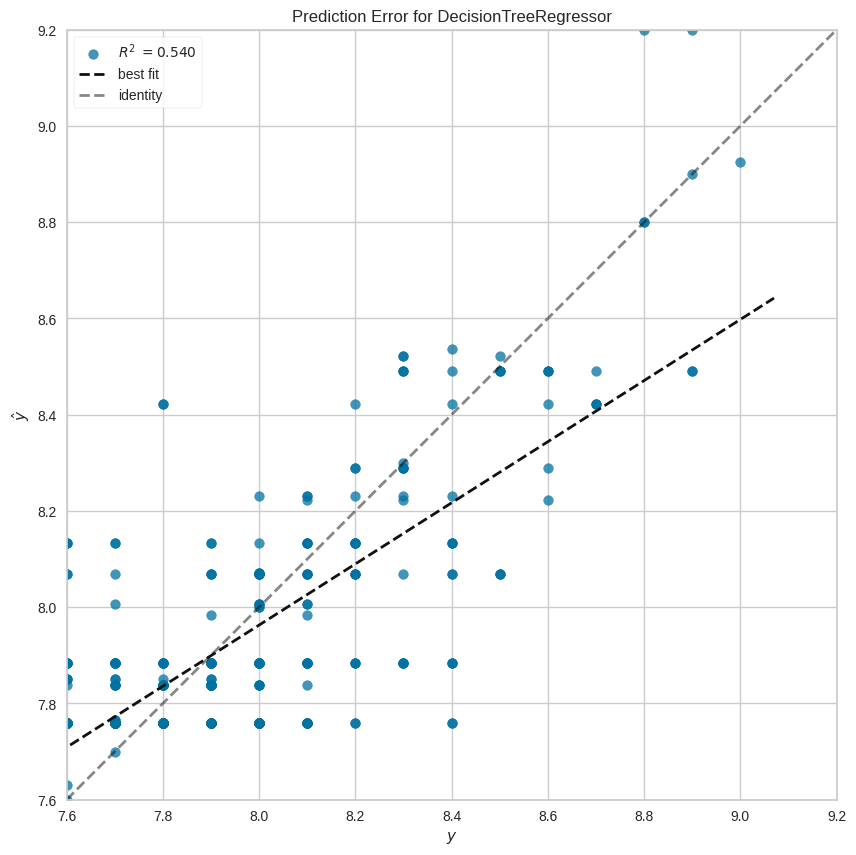

<Axes: title={'center': 'Prediction Error for DecisionTreeRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [199]:
from yellowbrick.regressor import PredictionError

fig, ax = plt.subplots(figsize = (10,10))
pev = PredictionError(dtr)
pev.fit(X_train, y_train)
pev.score(X_val, y_val)
pev.poof()

In [200]:
from sklearn.metrics import mean_absolute_error

mae_dtr = mean_absolute_error(y_val, pred_dtr)

print(f"Mean Absolute Error (MAE): {mae_dtr:.4f}")

Mean Absolute Error (MAE): 0.1468


###O teste com os dados de validação deram um resultado bastante positivo.Um valor de 0.1468 quer dizer que, em média, as previsões de nota IMDB do modelo estão errando por apenas 0.1468 pontos para mais ou para menos, em relação à nota real.

In [201]:
X_test.head()

,Released_Year,Certificate,Runtime,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Duration_Class,Genres_regrouped
674,1989,U,108,57.00,Robert Zemeckis,Michael J. Fox,Christopher Lloyd,Lea Thompson,Thomas F. Wilson,481918,118500000.00,short,Comedy
632,2003,UA,90,73.00,Satoshi Kon,Shôgo Furuya,Tôru Emori,Yoshiaki Umegaki,Aya Okamoto,31658,128985.00,short,"Animation, Family"
475,2016,UA,116,81.00,Denis Villeneuve,Amy Adams,Jeremy Renner,Forest Whitaker,Michael Stuhlbarg,594181,100546139.00,short,"Fantasy, Sci-Fi"
501,2008,UA,126,79.00,Jon Favreau,Robert Downey Jr.,Gwyneth Paltrow,Terrence Howard,Jeff Bridges,939644,318412101.00,medium,"Action, Adventure"
238,2003,UA,131,82.00,Bong Joon Ho,Kang-ho Song,Kim Sang-kyung,Roe-ha Kim,Jae-ho Song,139558,14131.00,medium,Crime


In [202]:
X_test = X_test.drop(columns=['Duration_Class', 'Director', 'Star1', 'Star2', 'Star3', 'Star4'], axis = 1)

cat_features = X_test.select_dtypes(exclude='number').columns
X_test = pd.get_dummies(X_test, columns = cat_features, drop_first=True, dtype=int)

In [203]:
#fazendo a previsão com os dados de teste
pred_dtr_test = dtr.predict(X_test)

In [204]:
mae_dtr_test = mean_absolute_error(y_test, pred_dtr_test)

print(f"Mean Absolute Error (MAE): {mae_dtr_test:.4f}")

Mean Absolute Error (MAE): 0.1483


###Com os dados de teste, o MAE ficou um pouquinho pior, mas ainda assim acima do resultado do MAE do modelo baseline, e um resultado muito bom.

## Construindo o modelo preditivo de floresta aleatória

Vantagens desse modelo:
* Menos risco de overfitting
* Lida bem com outliers
* Mais robusto, por trabalhar com várias árvores ao mesmo tempo.

Desvantagens:
* Como é um modelo mais robusto, demanda mais recursos computacionais

In [205]:
from sklearn.ensemble import RandomForestRegressor

In [206]:
rf = RandomForestRegressor(n_estimators = 10, random_state = 8, max_depth = 5)

In [207]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, n_estimators=10, random_state=8)

In [208]:
pred_rf = rf.predict(X_val)

In [209]:
mae_rf = mean_absolute_error(y_val, pred_rf)

print(f"Mean Absolute Error (MAE): {mae_rf:.4f}")

Mean Absolute Error (MAE): 0.1393


###Utilizando os dados de validação, o resultado deste modelo foi ainda melhor que o de árvore de decisão! Esse resultado significa que o modelo está operando com uma margem de erro de 0.1393 na previsão de cada nota.

####Gráfico de erro de predição

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


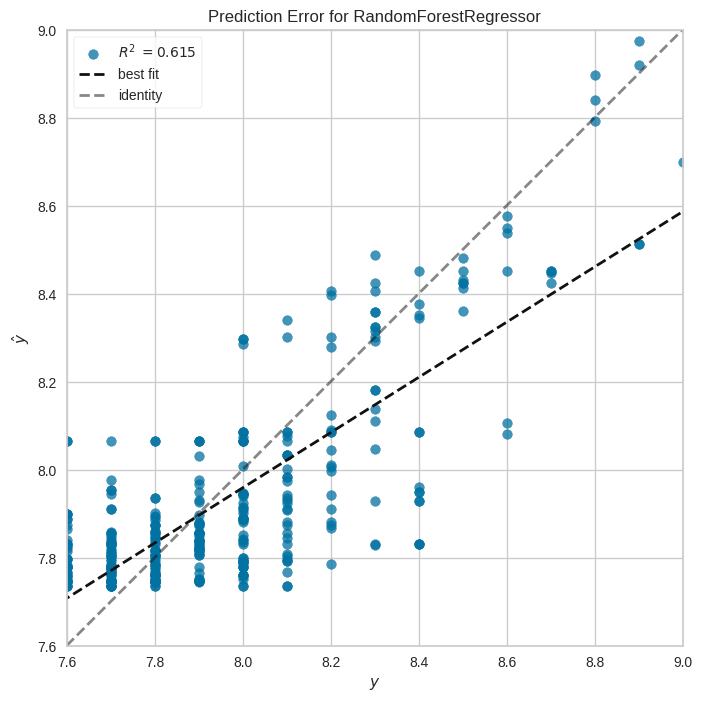

<Axes: title={'center': 'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [210]:
from yellowbrick.regressor import PredictionError

fig, ax = plt.subplots(figsize = (8,8))
pev = PredictionError(rf)
pev.fit(X_train, y_train)
pev.score(X_val, y_val)
pev.poof()

In [211]:
#fazendo a previsão com os dados de teste
pred_rf_test = dtr.predict(X_test)

In [212]:
mae_rf_test = mean_absolute_error(y_test, pred_rf_test)

print(f"Mean Absolute Error (MAE): {mae_rf_test:.4f}")

Mean Absolute Error (MAE): 0.1483


### Quando aplicamos a "prova final", ou seja, os dados de teste, notamos que o resultado dele é igual ao do modelo de árvore de decisão. Portanto, podemos considerar os dois modelos adequados para esse caso.

## Supondo um filme com as seguintes características:

{'Series_Title': 'The Shawshank Redemption',
 'Released_Year': '1994',
 'Certificate': 'A',
 'Runtime': '142 min',
 'Genre': 'Drama',
 'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
 'Meta_score': 80.0,
 'Director': 'Frank Darabont',
 'Star1': 'Tim Robbins',
 'Star2': 'Morgan Freeman',
 'Star3': 'Bob Gunton',
 'Star4': 'William Sadler',
 'No_of_Votes': 2343110,
 'Gross': '28,341,469'}


##Qual seria a nota do IMDB?


##Antes de tudo, vamos precisa repetir todo o pipeline de tratamento da base de dados realizada neste notebook, para que o novo dado esteja com as mesmas colunas dos dados com os quais o modelo foi treinado.

In [213]:

new_movie = {
    'Series_Title': 'The Shawshank Redemption',
    'Released_Year': '1994',
    'Certificate': 'A',
    'Runtime': '142 min',
    'Genre': 'Drama',
    'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
    'Meta_score': 80.0,
    'Director': 'Frank Darabont',
    'Star1': 'Tim Robbins',
    'Star2': 'Morgan Freeman',
    'Star3': 'Bob Gunton',
    'Star4': 'William Sadler',
    'No_of_Votes': 2343110,
    'Gross': '28,341,469'
}

new_movie = pd.DataFrame([new_movie])


In [214]:
new_movie

,Series_Title,Released_Year,Certificate,Runtime,Genre,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,The Shawshank Redemption,1994,A,142 min,Drama,Two imprisoned men bond over a number of years...,80.00,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469"


In [215]:
#Dropando as colunas que não utilizamos nos modelos:

new_movie = new_movie.drop(columns=['Series_Title', 'Overview', 'Director', 'Star1', 'Star2', 'Star3', 'Star4'], axis = 1)

In [216]:
#Tratar a coluna Runtime
new_movie['Runtime'] = new_movie['Runtime'].apply(lambda x: str(x).replace(" min", ""))
new_movie['Runtime'] = new_movie['Runtime'].astype('int64')


In [217]:
new_movie

,Released_Year,Certificate,Runtime,Genre,Meta_score,No_of_Votes,Gross
0,1994,A,142,Drama,80.00,2343110,"28,341,469"


In [218]:
#Tratando a coluna Gross

new_movie['Gross'] = new_movie['Gross'].apply(lambda x: str(x).replace(",", ""))

#convertendo a coluna Gross para o tipo float
new_movie['Gross'] = new_movie['Gross'].astype('float64')

In [219]:
#Tratando a coluna Released_Year
new_movie['Released_Year'] = new_movie['Released_Year'].astype('int64')

In [220]:
#Tratando a coluna Genre

new_movie['Genre_split'] = new_movie['Genre'].apply(lambda x: [genre.strip() for genre in x.split(',')])
new_movie = new_movie.explode('Genre_split')
mapping_genres = {'Action': 'Action, Adventure',
'Adventure': 'Action, Adventure',
'Western': 'Action, Adventure',
'War': 'Action, Adventure',

'Thriller': 'Thriller, Mystery, Horror',
'Mystery': 'Thriller, Mystery, Horror',
'Film-Noir': 'Thriller, Mystery, Horror',
'Horror': 'Thriller, Mystery, Horror',

'Drama': 'Drama, History',
'Biography': 'Drama, History',
'History': 'Drama, History',
'Sport': 'Drama, History',

'Sci-Fi': 'Fantasy, Sci-Fi',
'Fantasy': 'Fantasy, Sci-Fi',

'Animation': 'Animation, Family',
'Family': 'Animation, Family',

'Music': 'Musical',
'Musical': 'Musical'}
new_movie['Genres_regrouped'] = new_movie['Genre_split'].map(mapping_genres)
new_movie['Genres_regrouped'].fillna(new_movie['Genre_split'], inplace=True)

new_movie = new_movie.drop(columns='Genre')


/tmp/ipython-input-1008740865.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  new_movie['Genres_regrouped'].fillna(new_movie['Genre_split'], inplace=True)


In [221]:
new_movie

,Released_Year,Certificate,Runtime,Meta_score,No_of_Votes,Gross,Genre_split,Genres_regrouped
0,1994,A,142,80.00,2343110,28341469.00,Drama,"Drama, History"


In [222]:
#Tratando a coluna Certificate

classes = ['A', 'UA', 'U', 'R']

new_movie['Certificate_treated'] = np.where(new_movie['Certificate'].isin(classes), new_movie['Certificate'], 'Other')

new_movie = new_movie.drop("Certificate", axis = 1)


In [223]:

#One Hot Encoding

cat_features = new_movie.select_dtypes(exclude='number').columns

new_movie_transformed = pd.get_dummies(new_movie, columns = cat_features, dtype=int)

In [224]:
new_movie_transformed

,Released_Year,Runtime,Meta_score,No_of_Votes,Gross,Genre_split_Drama,"Genres_regrouped_Drama, History",Certificate_treated_A
0,1994,142,80.00,2343110,28341469.00,1,1,1


In [225]:
# Precisamos forçar o novo DataFrame a ter exatamente as mesmas colunas que X_train, preenchendo com 0 as que estiverem faltando.

# X_train.columns contém a lista de todas as colunas que o modelo espera
new_movie_transformed = new_movie_transformed.reindex(columns=X_train.columns, fill_value=0)

In [226]:
new_movie_transformed

,Released_Year,Runtime,Meta_score,No_of_Votes,Gross,Certificate_Other,Certificate_R,Certificate_U,Certificate_UA,"Genres_regrouped_Animation, Family",Genres_regrouped_Comedy,Genres_regrouped_Crime,"Genres_regrouped_Drama, History","Genres_regrouped_Fantasy, Sci-Fi",Genres_regrouped_Musical,Genres_regrouped_Romance,"Genres_regrouped_Thriller, Mystery, Horror"
0,1994,142,80.00,2343110,28341469.00,0,0,0,0,0,0,0,1,0,0,0,0


##Previsão da nota:

In [227]:
pred = rf.predict(new_movie_transformed)

print(f"A nota IMDB prevista é: {pred}")

A nota IMDB prevista é: [8.89599206]


##Já temos um modelo vencedor, mas como utilizá-lo fora do ambiente do Colab? Para isso, podemos exportá-lo utilizando o módulo Pickle e armazená-lo em arquivos serializados (ou seja, convertidos de objetos Python em uma representação binária que pode ser armazenada em um arquivo).

In [228]:
import pickle

In [229]:
#vamos salvar o modelo de floresta aleatória criado anteriormente
with open('model_random_forest.pkl', 'wb') as arquivo:
          pickle.dump(rf, arquivo)